# NLP Project - Analyse et modélisation

## Imports

In [1]:
import pandas as pd	
import string
import spacy
import re
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
import warnings
warnings.filterwarnings("ignore")
import joblib

2023-07-05 19:34:26.233673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 19:34:27.396785: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-05 19:34:28.889767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 19:34:28.890744: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

In [2]:
df = pd.read_csv('data/Emotion_final.csv')

## Explorer les données

### Répartitions des textes par émotions

In [3]:
emotions_count = df['Emotion'].value_counts()
print(emotions_count)

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64


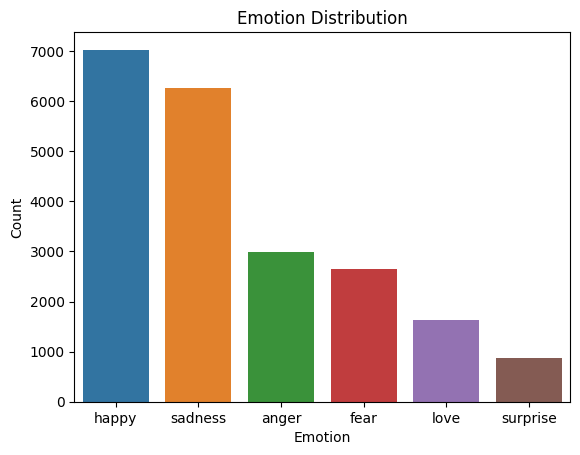

In [4]:
sns.barplot(x=emotions_count.index, y=emotions_count.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution')
plt.show()

### Affichage ponctuation et lettres isolées

In [5]:
# Créer une fonction pour compter les mots d'une seule lettre
def count_single_letter_words(text):
    # Séparer les mots en utilisant l'espace comme séparateur
    words = text.split()
    
    # Filtrer les mots d'une seule lettre
    single_letter_words = [word.lower() for word in words if len(word) == 1]
    
    # Retourner la liste des mots d'une seule lettre
    return single_letter_words

# Appliquer la fonction sur la colonne "Texte" pour obtenir les mots d'une seule lettre
df['Single Letter Words'] = df['Text'].apply(count_single_letter_words)

# Concaténer tous les mots d'une seule lettre dans une seule liste
all_single_letter_words = [word for words in df['Single Letter Words'] for word in words]

# Compter les occurrences des mots d'une seule lettre
single_letter_counts = pd.Series(all_single_letter_words).value_counts()

# Afficher le nombre d'occurrences et la lettre associée
for index, count in single_letter_counts.items():
    print(f"Lettre : {index}, Occurrence : {count}")
    
df = df.drop('Single Letter Words', axis=1)


Lettre : i, Occurrence : 32529
Lettre : a, Occurrence : 8333
Lettre : ,, Occurrence : 1338
Lettre : t, Occurrence : 1175
Lettre : s, Occurrence : 613
Lettre : m, Occurrence : 575
Lettre : `, Occurrence : 169
Lettre : ", Occurrence : 97
Lettre : d, Occurrence : 72
Lettre : u, Occurrence : 39
Lettre : b, Occurrence : 37
Lettre : :, Occurrence : 36
Lettre : ;, Occurrence : 36
Lettre : f, Occurrence : 30
Lettre : c, Occurrence : 25
Lettre : e, Occurrence : 25
Lettre : n, Occurrence : 22
Lettre : w, Occurrence : 20
Lettre : p, Occurrence : 20
Lettre : h, Occurrence : 18
Lettre : x, Occurrence : 17
Lettre : ?, Occurrence : 16
Lettre : r, Occurrence : 16
Lettre : o, Occurrence : 16
Lettre : ', Occurrence : 14
Lettre : y, Occurrence : 9
Lettre : k, Occurrence : 9
Lettre : ), Occurrence : 8
Lettre : (, Occurrence : 8
Lettre : v, Occurrence : 8
Lettre : !, Occurrence : 7
Lettre : l, Occurrence : 7
Lettre : g, Occurrence : 7
Lettre : q, Occurrence : 4
Lettre : j, Occurrence : 3
Lettre : z, Occurr

## Tokenisation

In [6]:
df['tokens'] = df['Text'].apply(lambda x: x.lower().split())

In [7]:
df.head()

,Text,Emotion,tokens
0,i didnt feel humiliated,sadness,"[i, didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,"[i, can, go, from, feeling, so, hopeless, to, ..."
2,im grabbing a minute to post i feel greedy wrong,anger,"[im, grabbing, a, minute, to, post, i, feel, g..."
3,i am ever feeling nostalgic about the fireplac...,love,"[i, am, ever, feeling, nostalgic, about, the, ..."
4,i am feeling grouchy,anger,"[i, am, feeling, grouchy]"


## Suppression des stopwords

In [8]:
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

## Suppression de la ponctuation et des lettres isolées

In [9]:
# Supprimer les mots d'une lettre
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if len(word) > 1])

# Supprimer la ponctuation
punctuation = string.punctuation
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in punctuation])

## Supression des émojis

In [10]:
# Définir une fonction pour supprimer les émojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symboles et pictogrammes
        u"\U0001F680-\U0001F6FF"  # transports et symboles de signalisation
        u"\U0001F1E0-\U0001F1FF"  # drapeaux (unicode drapeaux)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Supprimer les émojis des tokens
df['tokens'] = df['tokens'].apply(lambda x: [remove_emojis(word) for word in x])

## Suppression des nombres

In [11]:
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if not re.match(r'^\d+$', token)])

## Suppression des autres mots qui n'apportent pas d'informations

In [12]:
words_to_remove = ['feel', 'feeling', 'feelings', 'im', 'ive', 'get', 'got', 'do']
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in words_to_remove])

In [13]:
df['tokens'] = df['tokens'].apply(lambda x: [token if token != 'don' else 'dont' for token in x])

## Identification des 30 mots les plus courants pour chaque sentiment

In [14]:
# Créer un dictionnaire pour stocker les mots les plus courants par émotion
common_words_by_emotion = {}

# Parcourir chaque émotion unique
for emotion in df['Emotion'].unique():
    # Filtrer les lignes par émotion
    emotion_df = df[df['Emotion'] == emotion]
    
    # Concaténer les listes de tokens
    all_tokens = [token for tokens in emotion_df['tokens'] for token in tokens]
    
    # Compter les occurrences des mots
    word_counts = Counter(all_tokens)
    
    # Sélectionner les 30 mots les plus courants
    common_words = word_counts.most_common(30)
    
    # Ajouter les mots courants au dictionnaire par émotion
    common_words_by_emotion[emotion] = common_words
    
df_common_words = pd.DataFrame.from_dict(common_words_by_emotion, orient='index')
df_common_words = df_common_words.transpose()

df_common_words.head(31)


,sadness,anger,love,surprise,fear,happy
0,"(like, 1078)","(like, 479)","(like, 393)","(like, 121)","(like, 322)","(like, 1266)"
1,"(dont, 345)","(dont, 184)","(love, 119)","(amazed, 83)","(little, 194)","(time, 370)"
2,"(know, 344)","(people, 150)","(know, 101)","(impressed, 72)","(bit, 143)","(dont, 330)"
3,"(time, 270)","(know, 149)","(dont, 87)","(curious, 72)","(know, 139)","(know, 323)"
4,"(little, 267)","(time, 146)","(sweet, 84)","(overwhelmed, 69)","(anxious, 126)","(people, 266)"
5,"(want, 237)","(little, 136)","(loving, 82)","(funny, 68)","(dont, 125)","(want, 250)"
6,"(life, 228)","(want, 129)","(time, 82)","(surprised, 68)","(time, 119)","(good, 246)"
7,"(people, 226)","(angry, 116)","(want, 80)","(weird, 67)","(people, 106)","(little, 240)"
8,"(think, 222)","(think, 111)","(people, 80)","(strange, 60)","(nervous, 103)","(think, 239)"
9,"(bit, 220)","(things, 105)","(caring, 78)","(amazing, 56)","(want, 95)","(pretty, 236)"


## Heatmap

Métrique : nombre de mots en commun entre 2 sentiments dans le top 30 

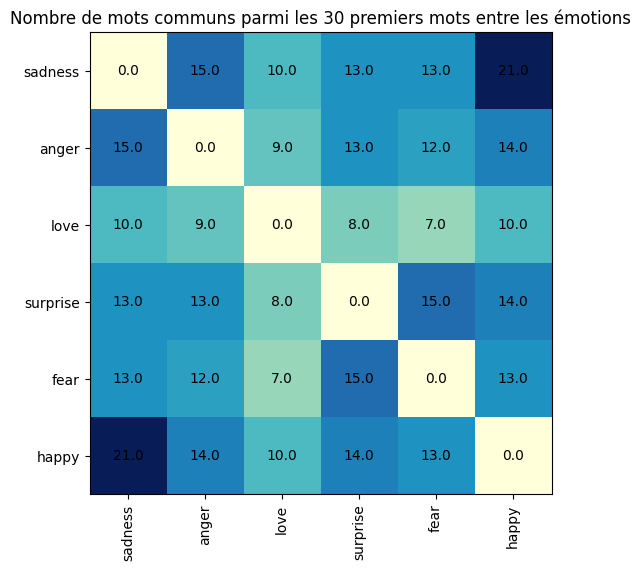

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Créer une matrice vide pour stocker le nombre de mots communs
num_common_words = np.zeros((len(common_words_by_emotion), len(common_words_by_emotion)))

# Parcourir les émotions
for i, emotion1 in enumerate(common_words_by_emotion.keys()):
    # Parcourir les émotions à partir de l'indice suivant
    for j, emotion2 in enumerate(list(common_words_by_emotion.keys())[i+1:]):
        # Récupérer les mots communs entre les deux émotions
        common_words = set(dict(common_words_by_emotion[emotion1]).keys()) & set(dict(common_words_by_emotion[emotion2]).keys())
        # Stocker le nombre de mots communs dans la matrice
        num_common_words[i, j+i+1] = len(common_words)
        num_common_words[j+i+1, i] = len(common_words)

# Créer un dataframe à partir de la matrice
df_common_words = pd.DataFrame(num_common_words, index=common_words_by_emotion.keys(), columns=common_words_by_emotion.keys())

# Créer une heatmap à partir du dataframe
plt.figure(figsize=(10, 6))
plt.imshow(df_common_words.values, cmap='YlGnBu')

# Ajouter des ticks et des labels
plt.xticks(range(len(df_common_words.columns)), df_common_words.columns, rotation=90)
plt.yticks(range(len(df_common_words.index)), df_common_words.index)

# Ajouter les valeurs des cellules
for i in range(len(df_common_words.index)):
    for j in range(len(df_common_words.columns)):
        plt.text(j, i, df_common_words.values[i, j], ha='center', va='center', color='black')

# Ajouter un titre
plt.title('Nombre de mots communs parmi les 30 premiers mots entre les émotions')

# Afficher la heatmap
plt.show()


## Preprocessing complet

In [16]:
df_2 = pd.read_csv('data/Emotion_final.csv')

In [17]:
personnalized_stopwords = ['feel', 'feeling','feelings', 'like','im','really', 'today','didnt','go', 'know', 'get', 'want', 'would', 'time', 'little', 'ive', 'still', 'even', 'one',  'people', 'think', 'bit', 'things', 'much', 'dont', 'make', 'day', 'something', 'back', 'going', 'way', 'could']

In [18]:
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    filtered_tokens = [token for token in tokens if not (nlp.vocab[token].is_punct or nlp.vocab[token].is_stop or len(token) < 3 or token.isnumeric() or token.isspace() or token.lower() in personnalized_stopwords)]    
    return ' '.join(filtered_tokens)

In [19]:
corpus = df_2['Text'].tolist()
corpus = [preprocess(text) for text in corpus]

### Bag of words

In [20]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(X.toarray())

['000' '12' '1997' ... 'zum' 'zumba' 'zzap']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [21]:
X_array = X.toarray()
if np.all(X_array == 0):
    print("Le tableau contient uniquement des zéros.")
else:
    print("Le tableau contient des valeurs différentes de zéro.")

Le tableau contient des valeurs différentes de zéro.


### TF-IDF

In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(X.toarray())

['000' '12' '1997' ... 'zum' 'zumba' 'zzap']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Modélisation (preprocess TF-IDF)

In [23]:
y = df['Emotion'].values

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
svc = LinearSVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.88


In [25]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.85


In [26]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.85


## Test du modèle

On utilise le modèle Linear SVC qui obtient la meilleur score de précision.

In [27]:
def predict_emotion(text, model, vectorizer, le):
    text = preprocess(text)
    X = vectorizer.transform([text])
    y_pred = model.predict(X)
    emotion = le.inverse_transform(y_pred)[0]
    return emotion

text = " Hello I am in tears"
emotion = predict_emotion(text, svc, vectorizer, le)
print(f"Emotion: {emotion}")


Emotion: sadness
